# Long, Wide Data and How to Efficiently Plot Them

---
## Introduction

Often times when we deal with data, it comes with different formats. If you scrapped the data from a website, likely it is in **wide format**. In fact most data we physically see is in this format, since wide data is very intuitive and easier to understand. One good example would be this [NBA stat page from ESPN](https://www.espn.com/nba/stats/player/_/table/offensive/sort/avgPoints/dir/desc). 

On the other hand, **long format** data is less often to see. However it has it's own advanges like:
   * fast processing (using vectorized operation)
   * required by certain advanced statistical analysis and graphing 

In this notebook, I'll show how to transform the data between the two formats, how is long format faster to process, and how to effeciently plot each format. We will use the monthly precipitation data for San Francisco and Sacramento as our examples. 

---

*Note: the weather data is retrieved from [this website](https://w2.weather.gov/climate/xmacis.php?wfo=mtr)  .*

## Data set and preparation

In [1]:
# import the necessary libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# load the data to dataframe, we retrieved two cities in California: San Francisco and Sacramento
# the two data sets have the same structure
sf = pd.read_csv('SF_rainfall.csv')
sac = pd.read_csv('Sacramento_rainfall.csv') 

In [3]:
sf.head(5)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
0,2000,6.41,8.96,2.04,1.66,1.40,0.16,0.02,0.02,0.21,2.38,0.85,0.90,25.01
1,2001,3.76,7.73,1.58,1.89,0.00,0.15,0.01,0.05,0.18,0.51,5.18,10.75,31.79
2,2002,2.13,2.59,2.27,0.52,0.84,0.03,0.00,0.03,0.01,0.01,2.00,12.03,22.46
3,2003,1.75,1.80,1.71,3.60,0.93,0.00,0.00,0.06,0.00,0.04,2.22,7.69,19.80
4,2004,3.40,5.67,1.16,0.12,0.12,0.00,0.00,0.05,0.04,2.62,2.07,7.98,23.23


In [4]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 14 columns):
Year      20 non-null int64
Jan       20 non-null float64
Feb       20 non-null float64
Mar       20 non-null float64
Apr       20 non-null float64
May       20 non-null float64
Jun       20 non-null float64
Jul       20 non-null float64
Aug       20 non-null float64
Sep       20 non-null float64
Oct       20 non-null float64
Nov       20 non-null float64
Dec       20 non-null object
Annual    20 non-null object
dtypes: float64(11), int64(1), object(2)
memory usage: 2.3+ KB


In [5]:
sf.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
15,2015,0.00,1.47,0.12,1.30,0.09,0.12,0.09,0.02,0.09,0.00,1.43,5.18,9.91
16,2016,6.94,0.98,6.83,1.46,0.15,0.00,0.02,0.02,0.00,2.43,2.21,4.39,25.43
17,2017,9.42,7.60,3.93,2.25,0.00,0.10,0.00,0.01,0.10,0.31,2.83,0.15,26.70
18,2018,5.21,0.21,4.54,3.91,0.04,0.01,0.00,0.00,0.00,0.21,3.56,2.18,19.87
19,2019,5.13,7.94,4.31,0.43,1.94,0.00,0.00,0.00,0.12,0.01,1.46,M,M


Here is our observation of the data:
1. Unit of the monthly percipitation is inch
2. The first eleven months' data are stored as float, however the month of December and annual total are not
3. We need to looking into the data and convet them into float
4. It's because we are still in December of this year...the data is not yet available

In [6]:
sf.iloc[:, -2:].applymap(type).apply(pd.value_counts)

,Dec,Annual
<class 'str'>,20,20


So the last two columns are all strings, next I need to conver the first 19 rows to float and find a way to fill the last row of Dec and Annual. 

In [7]:
# convert to float for last two columns
# we coerced the convertion of the last row, it will be 'NaN'
sf.iloc[:, 12:] = sf.iloc[:, 12:].apply(pd.to_numeric, errors = 'coerce')

Now that we have convert the strings to float, we can fill the last row with some educated guess. Here I will just use the averge percipitation of December of the last 19 years, and then sum up for year 2019.

In [8]:
# fill the last row
sf.iloc[19, 12] = round(sf.iloc[:-1, 12].mean(),2)
sf.iloc[19, 13] = sf.iloc[19, 1:-1].sum()

In [9]:
sf.tail(2)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
18,2018,5.21,0.21,4.54,3.91,0.04,0.01,0.0,0.0,0.00,0.21,3.56,2.18,19.87
19,2019,5.13,7.94,4.31,0.43,1.94,0.00,0.0,0.0,0.12,0.01,1.46,5.40,26.74


In [10]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 14 columns):
Year      20 non-null int64
Jan       20 non-null float64
Feb       20 non-null float64
Mar       20 non-null float64
Apr       20 non-null float64
May       20 non-null float64
Jun       20 non-null float64
Jul       20 non-null float64
Aug       20 non-null float64
Sep       20 non-null float64
Oct       20 non-null float64
Nov       20 non-null float64
Dec       20 non-null float64
Annual    20 non-null float64
dtypes: float64(13), int64(1)
memory usage: 2.3 KB


Next we do the same for the dataframe of Sacramento: sac

In [11]:
sac.iloc[:, 12:] = sac.iloc[:, 12:].apply(pd.to_numeric, errors = 'coerce')
sac.iloc[19, 12] = round(sac.iloc[:-1, 12].mean(),2)
sac.iloc[19, 13] = sac.iloc[19, 1:-1].sum()

In [12]:
sac.tail(2)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
18,2018,5.07,0.66,5.37,2.45,0.42,0.0,0.0,0.0,0.00,0.04,2.36,2.65,19.02
19,2019,4.65,8.90,3.20,0.59,3.42,0.0,0.0,0.0,0.06,0.00,0.71,3.69,25.22


## Data processing comparison

Next, we will do some manipulation of the data to show the difference between long and wide data.

First, let's convert them to long data and concat (or merge) the two dataframes into one.


In [13]:
months = list(sf.columns)[1:13]

# use pd.melt to convert to long data. 
sf_long = pd.melt(sf, id_vars = ['Year', 'Annual'], value_vars = months)
sf_long.rename(columns = {'variable': 'Month', 'value': 'Precipitation'}, inplace = True)

# add one column 'City' to distinguish the two data sets.
sf_long['City'] = 'SF'

# do the same for Sacramento
sac_long = pd.melt(sac, id_vars = ['Year', 'Annual'], value_vars = months)
sac_long.rename(columns = {'variable': 'Month', 'value': 'Precipitation'}, inplace = True)
sac_long['City'] = 'Sacramento'

In [14]:
# combine the two data sets
combine_long = pd.concat([sf_long, sac_long], sort = False)
combine_long

,Year,Annual,Month,Precipitation,City
0,2000,25.01,Jan,6.41,SF
1,2001,31.79,Jan,3.76,SF
2,2002,22.46,Jan,2.13,SF
3,2003,19.80,Jan,1.75,SF
4,2004,23.23,Jan,3.40,SF
...,...,...,...,...,...
235,2015,8.15,Dec,1.83,Sacramento
236,2016,22.86,Dec,3.77,Sacramento
237,2017,27.15,Dec,0.13,Sacramento
238,2018,19.02,Dec,2.65,Sacramento


Now say we want to calculate the monthly percentage of rainfall of each year. 

We can start with the wide data. Since we need to do the operation on each column, we can use the `apply` function.

In [15]:
def percentages(col, col_annual):
    div = col/col_annual
    return round(div*100,1)

monthly_perc = sf[months].apply(percentages, col_annual = sf['Annual'])
monthly_perc.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,25.6,35.8,8.2,6.6,5.6,0.6,0.1,0.1,0.8,9.5,3.4,3.6
1,11.8,24.3,5.0,5.9,0.0,0.5,0.0,0.2,0.6,1.6,16.3,33.8
2,9.5,11.5,10.1,2.3,3.7,0.1,0.0,0.1,0.0,0.0,8.9,53.6
3,8.8,9.1,8.6,18.2,4.7,0.0,0.0,0.3,0.0,0.2,11.2,38.8
4,14.6,24.4,5.0,0.5,0.5,0.0,0.0,0.2,0.2,11.3,8.9,34.4


In [16]:
combine_long['Percentages'] = round(combine_long['Precipitation']/combine_long['Annual']*100, 1)
combine_long.head()

,Year,Annual,Month,Precipitation,City,Percentages
0,2000,25.01,Jan,6.41,SF,25.6
1,2001,31.79,Jan,3.76,SF,11.8
2,2002,22.46,Jan,2.13,SF,9.5
3,2003,19.80,Jan,1.75,SF,8.8
4,2004,23.23,Jan,3.40,SF,14.6


Since the long data uses vectorized operation other than a for loop (wide data), it will be much more efficient for larger data sets.

## Plot using wide and long data
Next we will plot the boxplot for each month in the last twenty years first using the wide data.

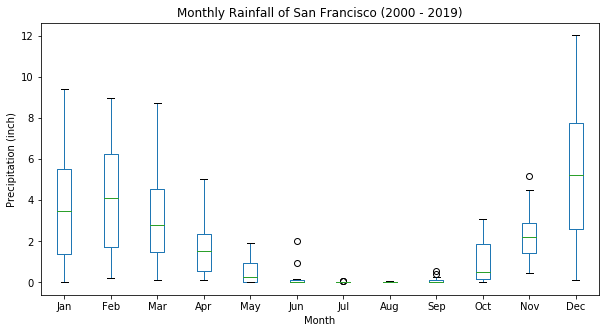

In [17]:
plt.figure(figsize = (10, 5))
sf_box = sf[months].boxplot(widths = 0.3, grid = False)
plt.xlabel('Month')
plt.ylabel('Precipitation (inch)')
plt.title('Monthly Rainfall of San Francisco (2000 - 2019)')
plt.show()

You can see it is quite easy to make the plot. What if we want to plot the data of Sacramento side by side. This becomes a fairly complex task for wide data. As you can see in the below, we have to plot the two dataframes separately, specify the width and position of each dataframe (otherwise they will overlap), and place the xticks at the center of two boxes. There is some tweeking involved to make it look right.

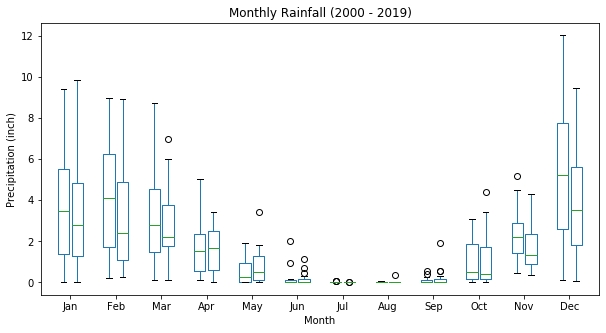

In [18]:
plt.figure(figsize = (10, 5))
sf_box = sf[months].boxplot(widths = 0.25, positions=np.arange(12), grid = False)
sac_box = sac[months].boxplot(widths = 0.25, positions=np.arange(0.3,12.3,1.0), grid = False)
plt.xlabel('Month')
plt.ylabel('Precipitation (inch)')
plt.title('Monthly Rainfall (2000 - 2019)')
plt.xticks(np.arange(0.15, 12.15, 1), months)

plt.show()

Now let's try to achieve the same using long farmat.

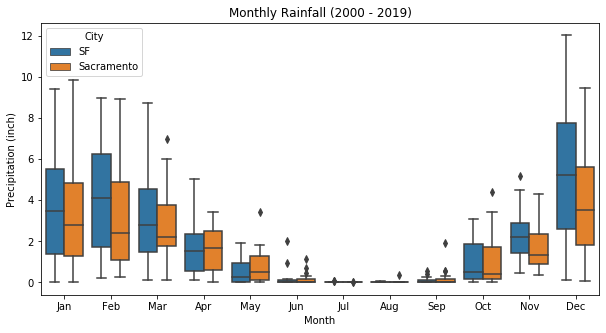

In [19]:
plt.figure(figsize = (10, 5))
sf_box_long = sns.boxplot(y = 'Precipitation', x = 'Month', hue = 'City', data = combine_long)
plt.xlabel('Month')
plt.ylabel('Precipitation (inch)')
plt.title('Monthly Rainfall (2000 - 2019)')
plt.show()

In this case, it's much easier to do the side-by-side comparison using long data and Seaborn. In `R`, `ggplot` also uses long format and the underline syntax is very similar to Seaborn.


## Thoughts
Coming from `R` and having extensively used `MATLAB` in my college, I liked `ggplot` a lot compared to `matplotlib` (which is similar to MATLAB). One reason is that I can easily make use of different variables to customized the plots. In above example, I used `hue` (color) to show a categorical variable. I can also include continuous variables in the visualization, for example: size of the symbol etc.